In [ ]:
!pip install scikeras
import os,scikeras,zipfile
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Conv1D, Input, MaxPooling1D, GlobalAveragePooling2D
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow.keras import models
from tensorflow.keras import layers
import pathlib
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from PIL import Image, ImageOps, ImageFilter, ImageEnhance#PIL是图像处理库
import torchvision.transforms as transforms#图像、视频、文本增强和预处理的库
import zipfile#对ZIP格式的归档文件进行读取、写入和操作
import warnings#避免一些可以忽略的报错
from keras.callbacks import EarlyStopping
warnings.filterwarnings('ignore')#filterwarnings()方法是用于设置警告过滤器的方法，它可以控制警告信息的输出方式和级别。

In [ ]:
print(os.listdir('/content/drive/MyDrive/Colab Notebooks/dogs-vs-cats-redux-kernels-edition'))#返回指定路径下的文件和目录名的列表
zip_files = ['test', 'train']

for zip_file in zip_files:
    with zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/dogs-vs-cats-redux-kernels-edition/{}.zip".format(zip_file),"r") as z:
        z.extractall(".")#解压
        print("{} unzipped".format(zip_file))

['sample_submission.csv', 'test.zip', 'train.zip', 'train', 'test']
test unzipped
train unzipped


In [ ]:
cwd = os. getcwd()
cwd

'/content'

In [ ]:
Train_Folder_Path = "/content/train"
Test_Folder_Path = "/content/test"
train_file_names = os.listdir(Train_Folder_Path)
test_file_names = os.listdir(Test_Folder_Path)

In [ ]:
len(train_file_names)
len(test_file_names)

12500

In [ ]:
label = []

for jpg in train_file_names:
    if jpg.split('.')[0] =='dog':
        label.append('1')
    else:
        label.append('0')

df = pd.DataFrame({
    'filename': train_file_names,
    'label': label})
df.head(5)

,filename,label
0,cat.4142.jpg,0
1,dog.8494.jpg,1
2,dog.7090.jpg,1
3,dog.4451.jpg,1
4,cat.10346.jpg,0


<Axes: xlabel='label', ylabel='count'>

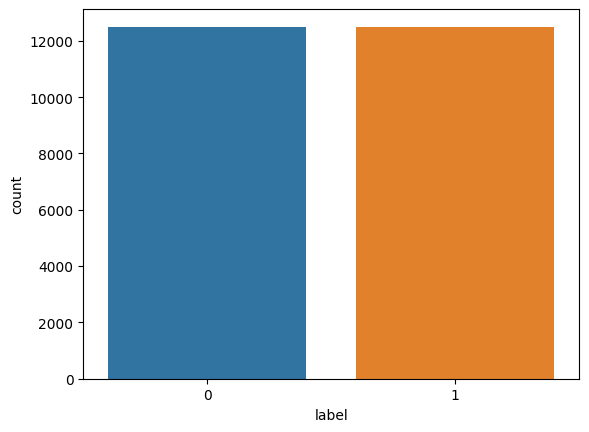

In [ ]:
df['label'].value_counts()
sns.countplot(df,x=df['label'])

In [ ]:
train, test = train_test_split(df, test_size=0.2, stratify=df['label'],shuffle = True, random_state=42)
print('# of training objects:\n',train['label'].value_counts())
print('# of validation objects:\n',test['label'].value_counts())

# of training objects:
 1    10000
0    10000
Name: label, dtype: int64
# of validation objects:
 1    2500
0    2500
Name: label, dtype: int64


## Use image augmentation method to preprocess the image data, trying to increase accuracy


In [ ]:
train_generator = ImageDataGenerator(
    rescale=1./255,               # 对图像进行归一化处理
    rotation_range=40,            # 图像随机旋转的角度范围
    width_shift_range=0.2,        # 图像在水平方向上随机平移的范围（相对总宽度的比例）
    height_shift_range=0.2,       # 图像在垂直方向上随机平移的范围（相对总高度的比例）
    shear_range=0.2,              # 随机剪切强度
    zoom_range=0.2,               # 随机缩放强度
    horizontal_flip=True,         # 随机水平翻转图像
    fill_mode='nearest'           # 填充新创建像素的方法
)
train_data = train_generator.flow_from_dataframe(train,
                                                directory = Train_Folder_Path,
                                                x_col = 'filename',
                                                y_col = 'label',
                                                class_mode = 'binary',
                                                seed = 42,
                                                target_size = (300,300),
                                                batch_size = 64)

Found 20000 validated image filenames belonging to 2 classes.


In [ ]:
test_generator = ImageDataGenerator(
    rescale=1./255,               # 对图像进行归一化处理
    rotation_range=40,            # 图像随机旋转的角度范围
    width_shift_range=0.2,        # 图像在水平方向上随机平移的范围（相对总宽度的比例）
    height_shift_range=0.2,       # 图像在垂直方向上随机平移的范围（相对总高度的比例）
    shear_range=0.2,              # 随机剪切强度
    zoom_range=0.2,               # 随机缩放强度
    horizontal_flip=True,         # 随机水平翻转图像
    fill_mode='nearest'           # 填充新创建像素的方法
)

test_data = test_generator.flow_from_dataframe(test,
                                               directory = Train_Folder_Path,
                                                x_col = 'filename',
                                                y_col = 'label',
                                                class_mode = 'binary',
                                                seed = 42,
                                                target_size = (300,300),
                                                batch_size = 64)

Found 5000 validated image filenames belonging to 2 classes.


## First, use basic CNN model to predict

CNN Model

In [ ]:
def catdog():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300,300, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = catdog()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 298, 298, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 147, 147, 64)      256       
 chNormalization)                                                
                                                        

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # Value to monitor
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

#Fit model
hist = model.fit(train_data,
                    validation_data = test_data,
                    initial_epoch = 7,
                    epochs = 11,
                    batch_size=32,
                    steps_per_epoch=np.ceil(20000/64),
                    validation_steps=np.ceil(5000/64),
                    callbacks=[early_stopping]
                    )

Epoch 8/11
313/313 [==============================] - 481s 1s/step - loss: 0.7248 - accuracy: 0.6474 - val_loss: 0.8922 - val_accuracy: 0.5126
Epoch 9/11
313/313 [==============================] - 463s 1s/step - loss: 0.5675 - accuracy: 0.7070 - val_loss: 0.5709 - val_accuracy: 0.7022
Epoch 10/11
313/313 [==============================] - 462s 1s/step - loss: 0.5476 - accuracy: 0.7220 - val_loss: 0.5376 - val_accuracy: 0.7294
Epoch 11/11
313/313 [==============================] - 463s 1s/step - loss: 0.5240 - accuracy: 0.7375 - val_loss: 0.5064 - val_accuracy: 0.7478


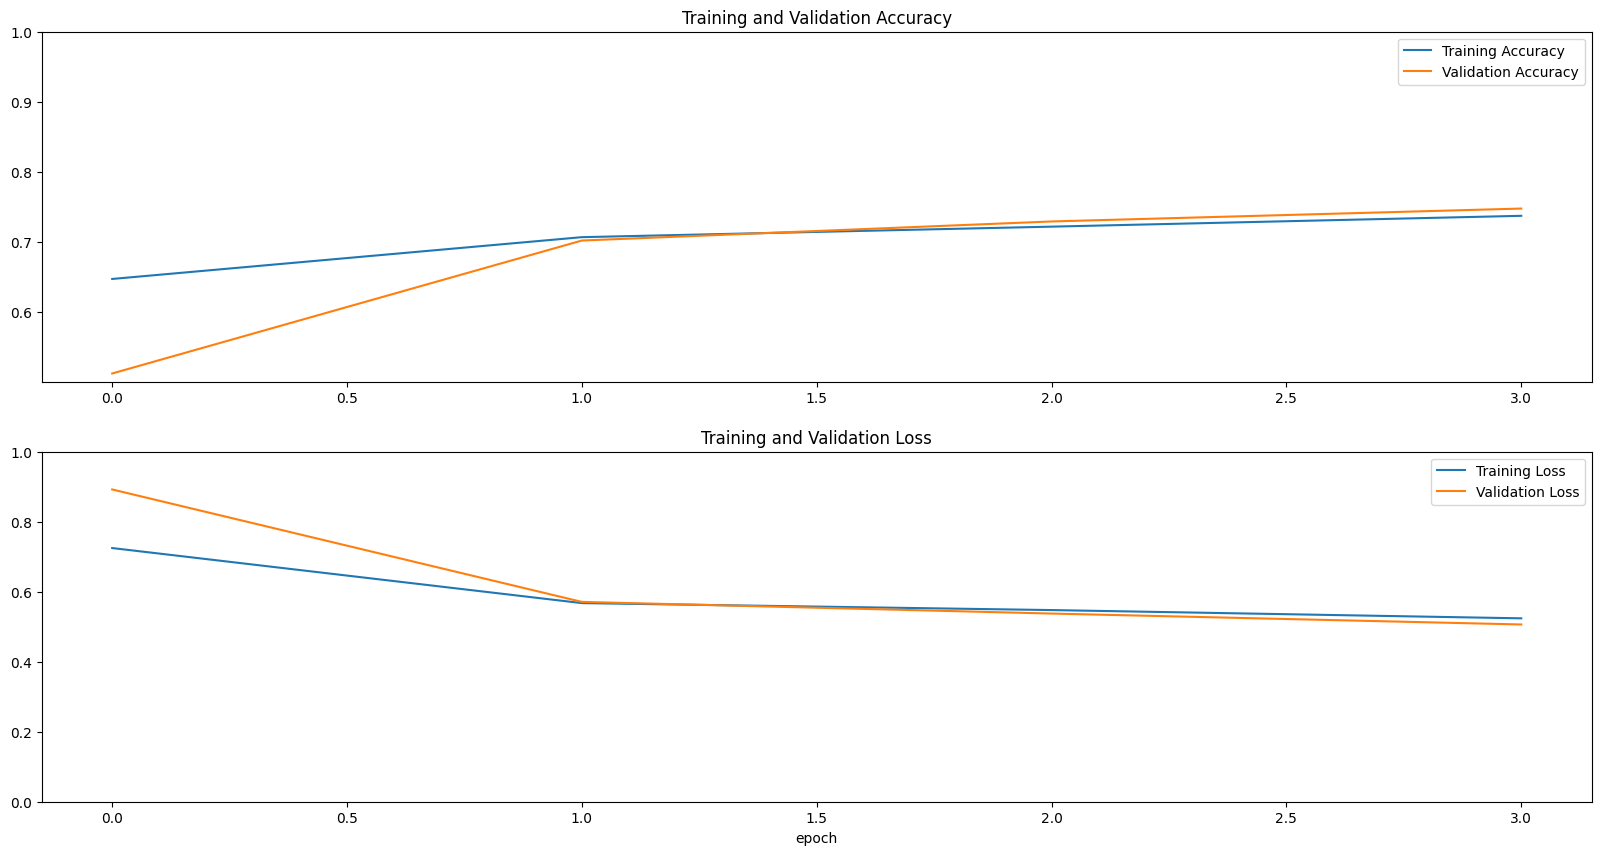

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Inception-Resnet
The accuracy of CNN model is not good enough, thus, I researched popular model for image classification, and modify, tune layers and hyperparameters

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

In [ ]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(300,300, 3))

base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

219055592/219055592 [==============================] - 11s 0us/step


In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics='accuracy')

In [ ]:
hist3 = model.fit(train_data,
                    validation_data = test_data,
                    initial_epoch = 6,
                    epochs = 11,
                    steps_per_epoch=np.ceil(20000/64),
                    validation_steps=np.ceil(5000/64)
                    )

Epoch 7/11
313/313 [==============================] - 495s 2s/step - loss: 0.0407 - accuracy: 0.9877 - val_loss: 0.0270 - val_accuracy: 0.9902
Epoch 8/11
313/313 [==============================] - 478s 2s/step - loss: 0.0370 - accuracy: 0.9872 - val_loss: 0.0335 - val_accuracy: 0.9878
Epoch 9/11
313/313 [==============================] - 482s 2s/step - loss: 0.0331 - accuracy: 0.9885 - val_loss: 0.0397 - val_accuracy: 0.9878
Epoch 10/11
313/313 [==============================] - 485s 2s/step - loss: 0.0313 - accuracy: 0.9895 - val_loss: 0.0321 - val_accuracy: 0.9886
Epoch 11/11
313/313 [==============================] - 480s 2s/step - loss: 0.0322 - accuracy: 0.9887 - val_loss: 0.0316 - val_accuracy: 0.9890


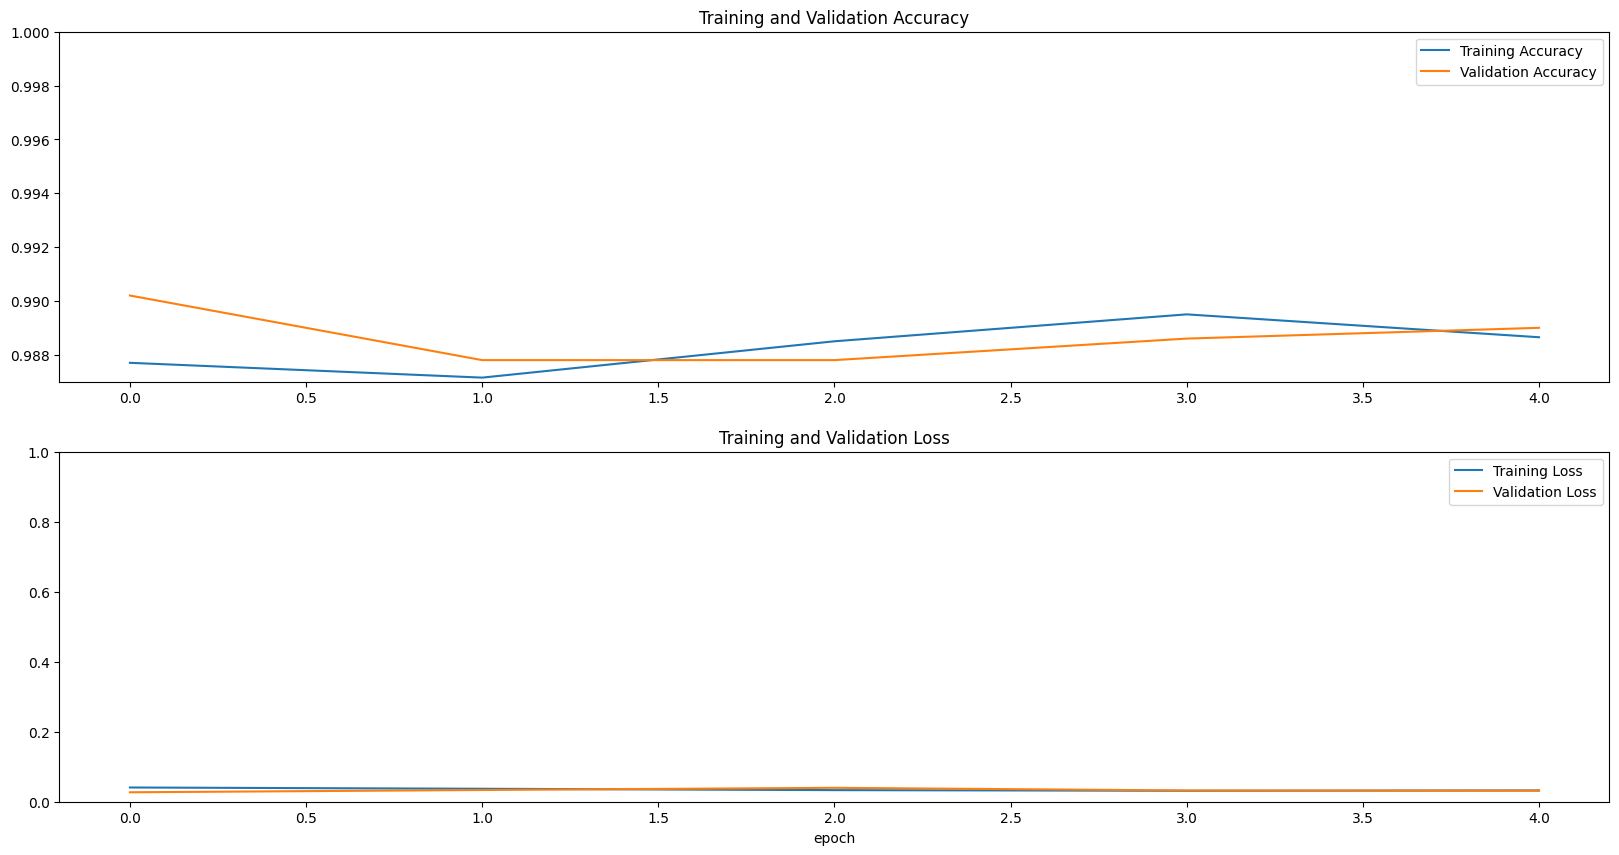

In [ ]:
acc = hist3.history['accuracy']
val_acc = hist3.history['val_accuracy']

loss = hist3.history['loss']
val_loss = hist3.history['val_loss']

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

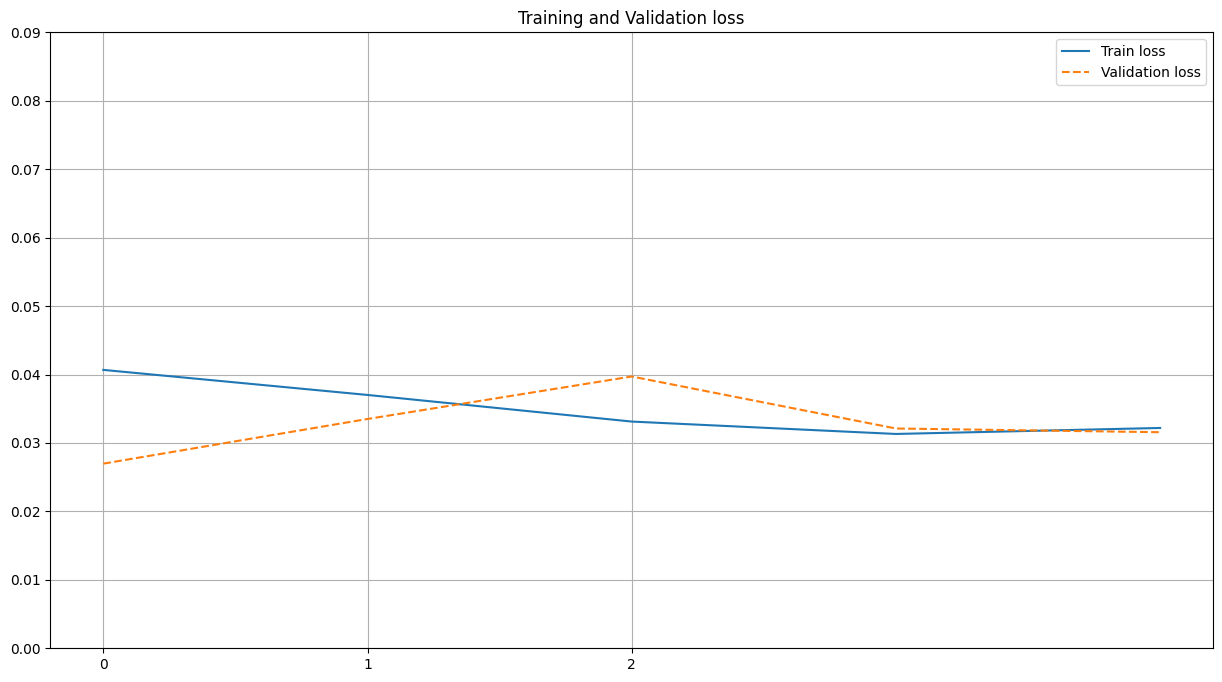

In [ ]:
loss = hist3.history['loss']
val_loss = hist3.history['val_loss']

plt.figure(figsize=(15,8))
plt.plot(loss, label='Train loss')
plt.plot(val_loss,'--', label='Validation loss')
plt.title('Training and Validation loss')
plt.xticks(np.arange(0,3))
plt.yticks(np.arange(0, 0.1, 0.01));
plt.grid()
plt.legend();

In [ ]:
base_model.trainable = True

len(base_model.layers)

780

# Layers Tuning


In [ ]:
for layer in base_model.layers[-8:]:
    layer.trainable = True

In [ ]:
# Compiling the new model

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics='accuracy')

In [ ]:
# Fitting the model

hist4 = model.fit(train_data,
                    validation_data = test_data,
                    initial_epoch = 6,
                    epochs = 11,
                    steps_per_epoch=np.ceil(20000/64),
                    validation_steps=np.ceil(5000/64)
                    )

Epoch 7/11
313/313 [==============================] - 821s 2s/step - loss: 0.0458 - accuracy: 0.9840 - val_loss: 0.0265 - val_accuracy: 0.9902
Epoch 8/11
313/313 [==============================] - 738s 2s/step - loss: 0.0252 - accuracy: 0.9915 - val_loss: 0.0255 - val_accuracy: 0.9914
Epoch 9/11
313/313 [==============================] - 736s 2s/step - loss: 0.0208 - accuracy: 0.9925 - val_loss: 0.0406 - val_accuracy: 0.9864
Epoch 10/11
313/313 [==============================] - 737s 2s/step - loss: 0.0185 - accuracy: 0.9940 - val_loss: 0.0488 - val_accuracy: 0.9854
Epoch 11/11
313/313 [==============================] - 736s 2s/step - loss: 0.0155 - accuracy: 0.9943 - val_loss: 0.1722 - val_accuracy: 0.9362


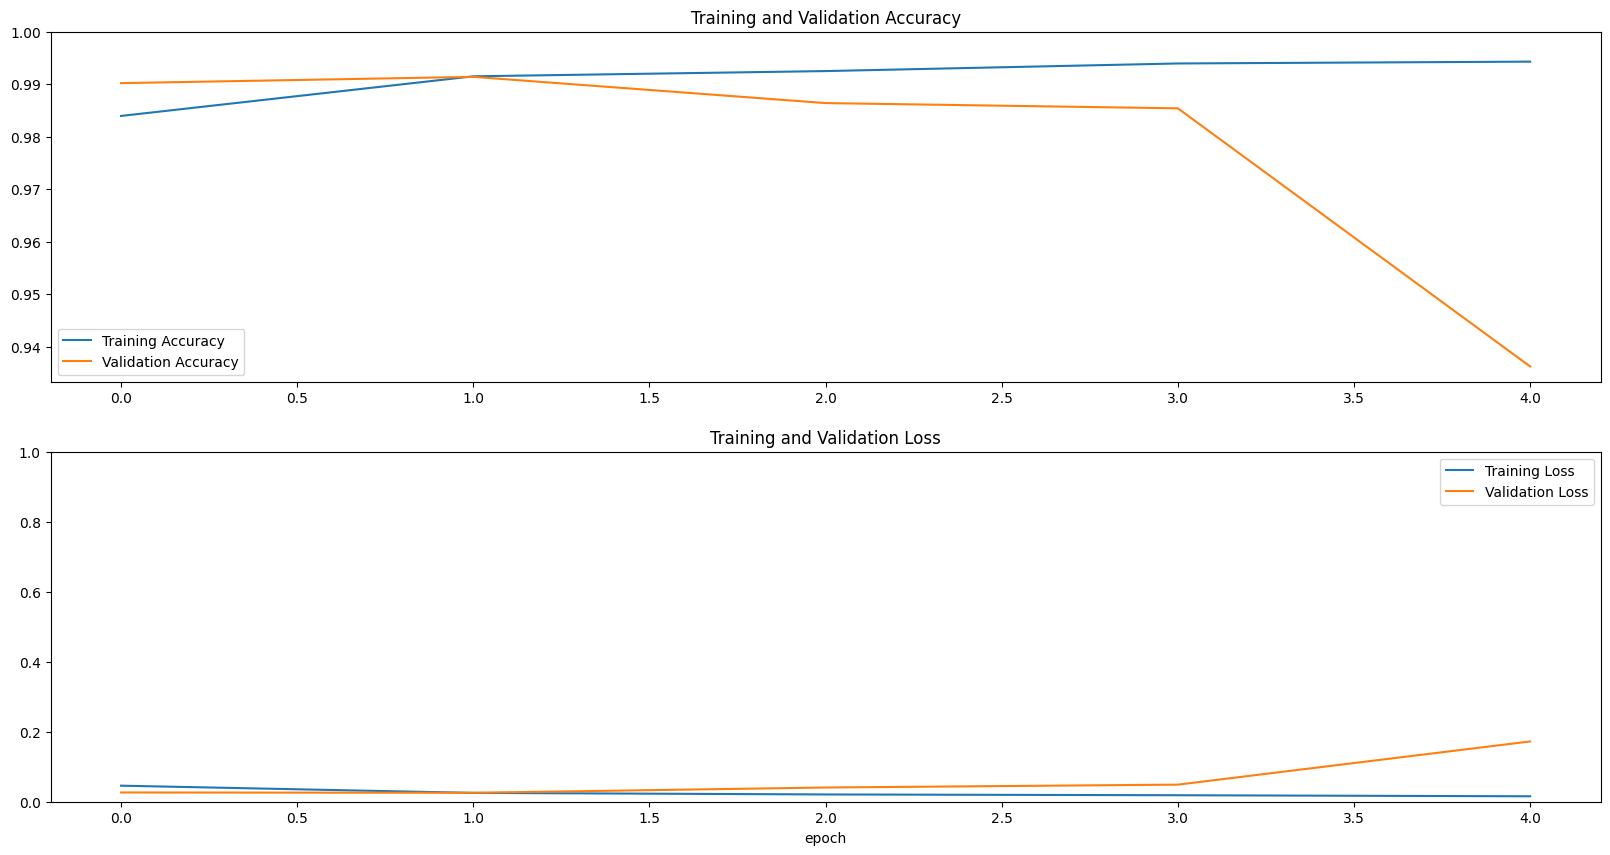

In [ ]:
acc = hist4.history['accuracy']
val_acc = hist4.history['val_accuracy']

loss = hist4.history['loss']
val_loss = hist4.history['val_loss']

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

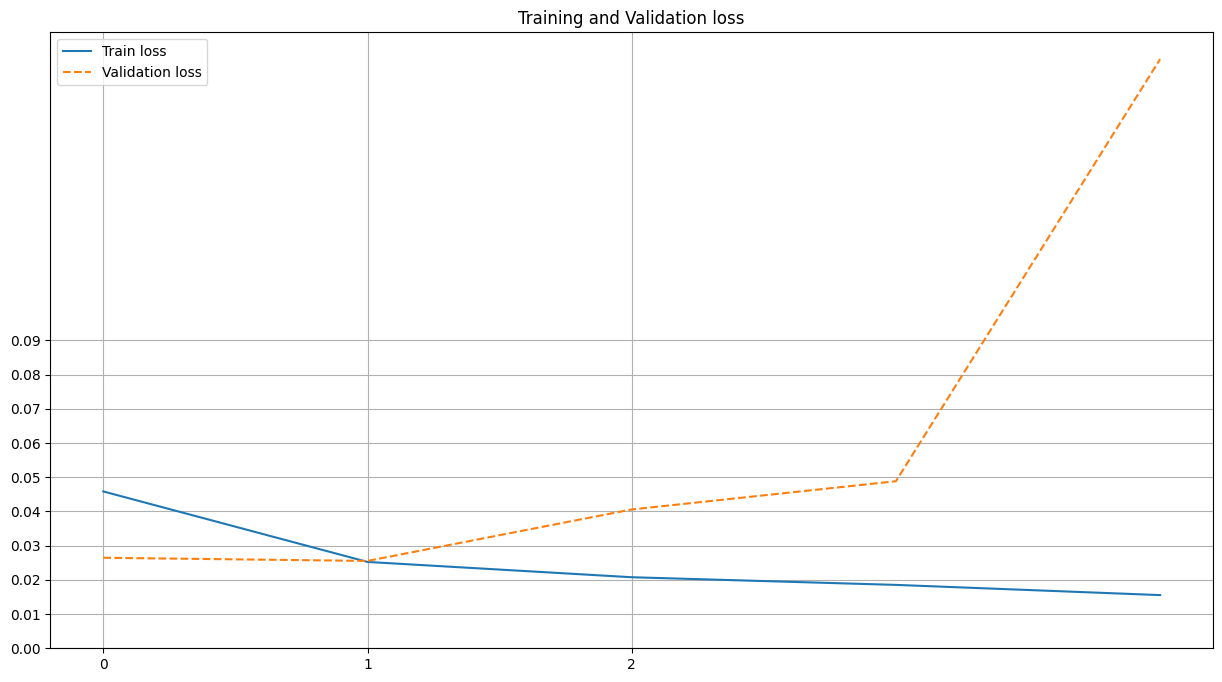

In [ ]:
loss = hist4.history['loss']
val_loss = hist4.history['val_loss']

plt.figure(figsize=(15,8))
plt.plot(loss, label='Train loss')
plt.plot(val_loss,'--', label='Validation loss')
plt.title('Training and Validation loss')
plt.xticks(np.arange(0,3))
plt.yticks(np.arange(0, 0.1, 0.01));
plt.grid()
plt.legend();

## Export prediction results for submission

In [ ]:
files2 = os.listdir(Test_Folder_Path)
df_test = pd.DataFrame({
            'filename2':files2,
            })

In [ ]:
ids = []

for i in files2:
    ids.append(i.split(".")[0])

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)

test_data = test_gen.flow_from_dataframe(df_test,
                                        directory=Test_Folder_Path,
                                        x_col='filename2',
                                        y_col= None,
                                        class_mode=None,
                                        seed=42,
                                        target_size=(300,300),
                                        batch_size=64,
                                        shuffle=False)

Found 12500 validated image filenames.


In [ ]:
prediction = model.predict(test_data, steps=np.ceil(12500/64))

196/196 [==============================] - 122s 607ms/step


In [ ]:
labels = []

for i in prediction:
    labels.append(i[0])


In [ ]:
# Generating final dataframe and CSV
df_test = pd.DataFrame({
                        'id':ids,
                        'label':labels
                        })

df_test.to_csv("submission5.csv", index=False)